In [144]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import wordpunct_tokenize, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import gensim
from gensim import corpora


In [64]:
def print_results(_test, _y_test, _y_hat, _y_proba):
    print('Accuracy  :', accuracy_score(_y_test, _y_hat))
    print('F1        :', f1_score(_y_test, _y_hat))
    print('Precision :', precision_score(_y_test, _y_hat))
    print('Recall    :', recall_score(_y_test, _y_hat))

    if  len(_y_proba) == 0:
        return

    print('Roc Auc   :', roc_auc_score(_y_test, _y_proba))
    fpr, tpr, thresh = roc_curve(_y_test, _y_proba)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## Import Data (Part 1, 2, & 3)

In [87]:
wn = WordNetLemmatizer()
sw = stopwords.words('english')

def text_token(x):
    x = str(x)
    x = x.lower()
    tokens = wordpunct_tokenize(x)
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    tokens = [wn.lemmatize(tok) for tok in tokens]
    return(tokens)

In [129]:
df = pd.read_csv('ratings.tsv', sep='\t', header=1)
df.columns = ['target', 'text']
df['tokens'] = df['text'].apply(text_token)
df['clean'] = df['tokens'].apply(lambda x: " ".join(x))

train_raw, test_raw = train_test_split(df, test_size=.33, stratify=df.target, random_state=801)


y_train = (train_raw['target']=='pos').astype(int)
y_test = (test_raw['target']=='pos').astype(int)
y_all = (df['target']=='pos').astype(int)

## Vectorize Data (Part 4)

In [92]:
tfidf = TfidfVectorizer()
tfidf.fit(train_raw['clean'].values.astype('U'))
train = tfidf.transform(train_raw['clean'].values.astype('U'))
test = tfidf.transform(test_raw['clean'].values.astype('U'))

## Suport Vector

In [93]:
sv = svm.SVC()
sv.fit(train, y_train)
y_hat = sv.predict(test)
print_results(test, y_test, y_hat, [])

Accuracy  : 0.9071969696969697
F1        : 0.9083426861204639
Precision : 0.8972653362897265
Recall    : 0.9196969696969697


## Multilayer Perceptron

Accuracy  : 0.9030303030303031
F1        : 0.9028094153378892
Precision : 0.9048706240487062
Recall    : 0.9007575757575758
Roc Auc   : 0.9653833792470156


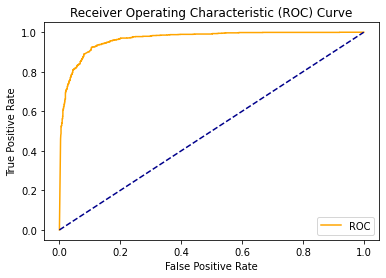

In [94]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(200, 20), random_state=1)
mlp.fit(train, y_train)
y_hat = mlp.predict(test)
y_prob = mlp.predict_proba(test)[:,1]
print_results(test, y_test, y_hat, y_prob)

## Multinomial Naive Bayes

Accuracy  : 0.8875
F1        : 0.8829325975561687
Precision : 0.9202958093672966
Recall    : 0.8484848484848485
Roc Auc   : 0.9627152203856749


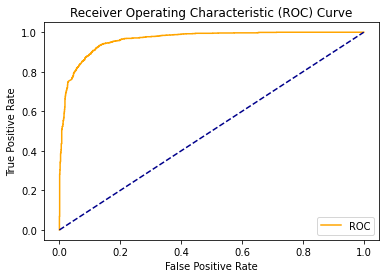

In [95]:
nb = MultinomialNB()
nb.fit(train, y_train)
y_hat = nb.predict(test)
y_prob = nb.predict_proba(test)[:,1]
print_results(test, y_test, y_hat, y_prob)

In [ ]:
## Important words

In [102]:
feats = pd.DataFrame()
feats['words'] = tfidf.get_feature_names()
# Convert log probabilities to probabilities. 
feats['neg'] = np.e**(nb.feature_log_prob_[0, :])
feats['pos'] = np.e**(nb.feature_log_prob_[1, :])
feats['impact'] = abs(feats['pos'] - feats['neg'])
feats.set_index('words', inplace=True)

In [163]:
feats.sort_values(by='impact',ascending=False).head(25)

C:\Users\Michael\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,neg,pos,impact
words,,,
bad,0.001248,0.000242,0.001006
movie,0.002739,0.002032,0.000707
worst,0.000707,0.000051,0.000657
great,0.000356,0.000937,0.000581
br,0.003734,0.003159,0.000575
waste,0.000461,0.000032,0.000429
love,0.000349,0.000774,0.000425
terrible,0.000461,0.000062,0.000399
even,0.000936,0.000543,0.000393


## Vader

In [131]:
sid = SentimentIntensityAnalyzer()
df['scores'] = df['text'].apply(lambda x: sid.polarity_scores(str(x)))
df['compound'] = df['scores'].apply(lambda x: x['compound'])

0   -0.8618
1    0.9951
2    0.9972
3   -0.2484
4   -0.9855
Name: compound, dtype: float64

Accuracy  : 0.7064633079134892
F1        : 0.7458874458874459
Precision : 0.6576335877862596
Recall    : 0.8615
Roc Auc   : 0.7911544448612153


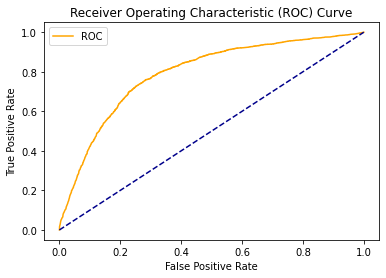

In [132]:
y_hat = df['compound'].apply(lambda x: int(x > 0))
y_prob = df['compound'].apply(lambda x: (x+1)/2)
print_results(test, y_all, y_hat, y_prob)

## TextBlob

In [139]:
df['sentiment'] = df['text'].apply(lambda val: TextBlob(str(val)).sentiment.polarity)

Accuracy  : 0.702337792224028
F1        : 0.7610637230306072
Precision : 0.6357082984073764
Recall    : 0.948
Roc Auc   : 0.8702040197549389


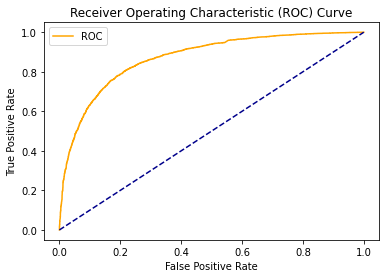

In [141]:
y_hat = df['sentiment'].apply(lambda x: int(x > 0))
y_prob = df['sentiment'].apply(lambda x: (x+1)/2)
print_results(test, y_all, y_hat, y_prob)

## Gensim

In [145]:
df.head()

,target,text,tokens,clean,scores,compound,sentiment
0,neg,some talented actresses are blessed with a dem...,"[talented, actress, blessed, demonstrated, wid...",talented actress blessed demonstrated wide act...,"{'neg': 0.12, 'neu': 0.775, 'pos': 0.105, 'com...",-0.8618,0.083156
1,pos,this has been an extraordinary year for austra...,"[extraordinary, year, australian, film, shine,...",extraordinary year australian film shine scoop...,"{'neg': 0.068, 'neu': 0.781, 'pos': 0.15, 'com...",0.9951,0.139608
2,pos,according to hollywood movies made in last few...,"[according, hollywood, movie, made, last, deca...",according hollywood movie made last decade lif...,"{'neg': 0.071, 'neu': 0.782, 'pos': 0.147, 'co...",0.9972,0.121206
3,neg,my first press screening of 1998 and already i...,"[first, press, screening, 1998, already, gotte...",first press screening 1998 already gotten prim...,"{'neg': 0.091, 'neu': 0.817, 'pos': 0.093, 'co...",-0.2484,-0.027738
4,neg,"to put it bluntly , ed wood would have been pr...","[put, bluntly, ed, wood, would, proud, totally...",put bluntly ed wood would proud totally ridicu...,"{'neg': 0.123, 'neu': 0.821, 'pos': 0.056, 'co...",-0.9855,0.009623


In [153]:
dictionary = corpora.Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(text) for text in df["tokens"].values.tolist()]



In [167]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

C:\Users\Michael\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [168]:
ldatopics = lda_model.show_topics(formatted=False)
print(lda_model.print_topics())

[(0, '0.000*"nan" + 0.000*"pokemon" + 0.000*"cagney" + 0.000*"sheedy" + 0.000*"hazel" + 0.000*"scoop" + 0.000*"pioneer" + 0.000*"johansson" + 0.000*"fc" + 0.000*"texan"'), (1, '0.012*"young" + 0.011*"child" + 0.008*"boy" + 0.008*"dance" + 0.007*"son" + 0.007*"course" + 0.006*"hero" + 0.006*"old" + 0.006*"king" + 0.006*"city"'), (2, '0.096*"movie" + 0.021*"good" + 0.014*"bad" + 0.013*"think" + 0.013*"made" + 0.012*"like" + 0.012*"ever" + 0.012*"even" + 0.011*"acting" + 0.010*"plot"'), (3, '0.016*"life" + 0.015*"film" + 0.014*"love" + 0.014*"story" + 0.013*"character" + 0.012*"great" + 0.012*"performance" + 0.011*"real" + 0.011*"friend" + 0.011*"best"'), (4, '0.070*"film" + 0.015*"production" + 0.014*"art" + 0.014*"please" + 0.010*"spoiler" + 0.009*"director" + 0.009*"thinking" + 0.009*"cinema" + 0.008*"work" + 0.008*"single"'), (5, '0.027*"film" + 0.025*"one" + 0.016*"time" + 0.012*"would" + 0.012*"see" + 0.012*"like" + 0.011*"people" + 0.010*"get" + 0.010*"show" + 0.009*"first"'), (6, 

In [169]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='mmds')
vis

C:\Users\Michael\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.147441 -0.430630       1        1  38.395115
2     -0.169230 -0.397114       2        1  21.253557
3     -0.396020 -0.174576       3        1  15.117654
1     -0.322331  0.303365       4        1   9.053101
4      0.316741 -0.154145       5        1   6.143842
7      0.413433  0.163975       6        1   3.811918
6      0.092309  0.394970       7        1   3.772850
8     -0.166927  0.039487       8        1   2.304637
9      0.042291  0.127334       9        1   0.073667
0      0.042293  0.127333      10        1   0.073667, topic_info=            Term          Freq         Total Category  logprob  loglift
25270         br  26901.000000  26901.000000  Default  30.0000  30.0000
151        movie  29085.000000  29085.000000  Default  29.0000  29.0000
91          film  20667.000000  20667.000000  Default  28.0000  28.0000
613         good   5475.000000   5475.000000  Default  27.0000  27.0000
247         time   7732.000000   7732.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
18832    frankie      0.020273      1.797406  Topic10 -10.7068   2.7286
44283  dillinger      0.020273      1.641254  Topic10 -10.7068   2.8195
22377    pimlico      0.020273      1.917543  Topic10 -10.7068   2.6639
25301     barton      0.020273      1.576037  Topic10 -10.7068   2.8600
29443    digimon      0.020273      1.595482  Topic10 -10.7068   2.8477

[553 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         2  0.998954      1
2255      1  0.999435     10
5519      8  0.994191    100
1804      2  0.999330      2
2         2  0.998778      3
...     ...       ...    ...
263       3  0.186908   year
263       4  0.002517   year
1564      2  0.274025    yet
1564      3  0.725271    yet
1019      4  0.998658  young

[438 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 4, 2, 5, 8, 7, 9, 10, 1])